# Figure 11.
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/23/2025          |
| Updated |  08/23/2025          |

Similar to Figure 10 except for models that also include the frequency-dependent isotropic scattering opacities $\kappa^\mathrm{sca}$ (Section 4.3.2) shown in Figure 2.

Opacity		Section	Latitude	Optical Depths		Rel. Diff. in \Teq(θ)
								Avg.	Max.
(cm^2\gm^{-1})		(deg)					(%)	(%)
(1)		(2)	(4)		(5)			(6/8)	(7/9)
\knuabssca	4.3.2						Multigroup
			30		3e-09 < τ < 2e-06	3%	4%
			10		3e-05 < τ < 2e+02	2%	4%
			0		5e-01 < τ < 2e+04	5%	8%


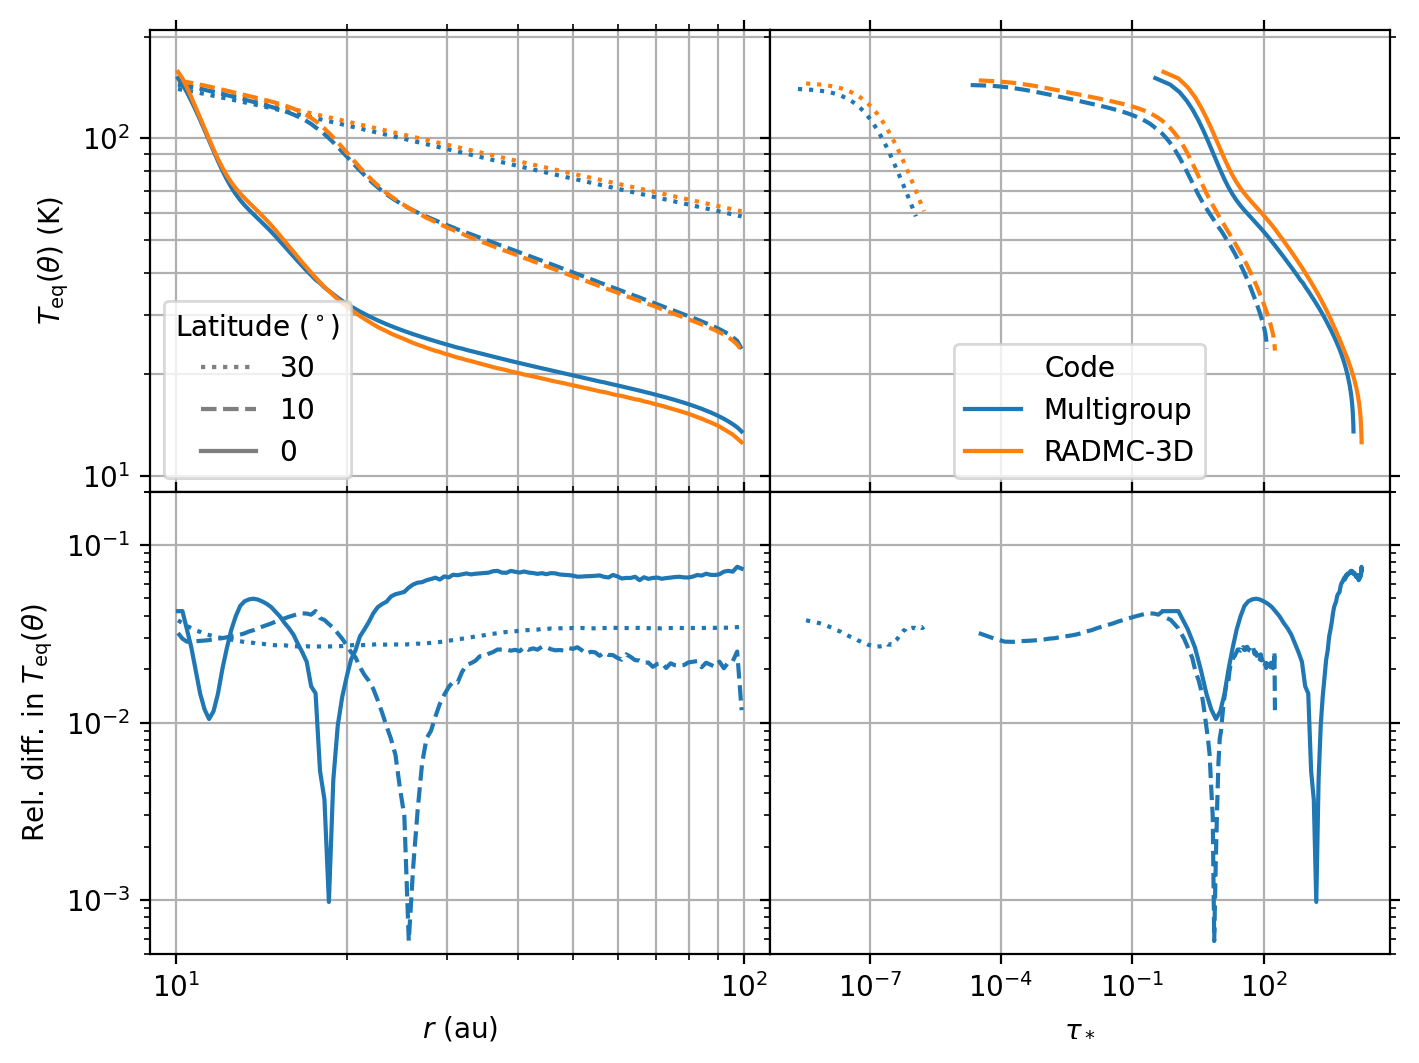

In [2]:
#===============================================================================
import athena_read
import matplotlib.pyplot as plt
import numpy as np

# Constants
au = 1.495978707e13           # astronomical unit [cm]
rad2deg = 180/np.pi

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
lss = ['dotted', 'dashed', 'solid']
theta_degs = [60, 80, 90]
c_solns, ls_thetas = [], []

# RADMC-3D
root = '../radmc3d'
run = 'dsharp_abs-sca'
path = f'{root}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']

# Athena++
root = '../athena/models/dsharp_abs-sca/nfreq'
run = '64'
problem_id = 'dsharp'
print('Opacity\t\tSection\tLatitude\tOptical Depths\t\tRel. Diff. in \Teq(θ)')
print(f'\t\t\t\t\t\t\t\tAvg.\tMax.')
print('(cm^2\gm^{-1})\t\t(deg)\t\t\t\t\t(%)\t(%)')
print('(1)\t\t(2)\t(4)\t\t(5)\t\t\t(6/8)\t(7/9)')
path = f'{root}/{run}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
length_unit = athinput['radiation']['length_unit']
t_unit = athinput['radiation']['T_unit']
l_au = length_unit/au
dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
          /athinput['mesh']['nx2']
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
f_star = 54
dtau = (athdf[f'Sigma_a_{f_star}'][0] + athdf[f'Sigma_s_{f_star}'][0])\
       *np.diff(athdf['x1f'])
tau = np.cumsum(dtau, axis=1)
temps = athdf['press'][0]/athdf['rho'][0]
print(f'\knuabssca\t4.3.2\t\t\t\t\t\tMultigroup')
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    rel_diff_temp = 2*np.abs(temps[j, :]*t_unit - dusttemp[:,j,0,0])\
                    /(temps[j, :]*t_unit + dusttemp[:,j,0,0])
    axs[0][0].plot(athdf['x1v']*l_au, temps[j, :]*t_unit, color='tab:blue',
                ls=lss[th])
    axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color='tab:orange', ls=lss[th])
    axs[0][1].plot(tau[j, :], temps[j, :]*t_unit, color='tab:blue',
                   ls=lss[th])
    axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color='tab:orange',
                   ls=lss[th])
    axs[1][0].plot(athdf['x1v']*l_au, rel_diff_temp, color='tab:blue',
                   ls=lss[th])
    axs[1][1].plot(taux[:,j,0], rel_diff_temp, color='tab:blue', ls=lss[th])
    ls_thetas.append(axs[0][1].plot([], [], color='tab:gray', ls=lss[th],
                 label=rf'${90-theta_deg}$')[0])
    print(f'\t\t\t{90-theta_deg}\t\t{np.min(taux[:,j,0]):.0e} < τ < '\
          +f'{np.max(taux[:,j,0]):.0e}\t{np.mean(rel_diff_temp):.0%}\t'
          +f'{np.max(rel_diff_temp):.0%}')
c_solns.append(axs[1][1].plot([], [], color='tab:blue', label=f'Multigroup')[0])
c_solns.append(axs[1][1].plot([], [], color='tab:orange', label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
axs[0][0].add_artist(axs[0][0].legend(framealpha=0.56, handles=ls_thetas,
                                      title=r'Latitude ($^\circ)$'))
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=c_solns,
                                      loc='lower center', title=r'Code'))

# Format plots
for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0][0].grid(axis='both', which='minor')
axs[0][1].grid(axis='y', which='minor')
axs[1][0].grid(axis='x', which='minor')
axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)', ylim=(9, 2.1e2))
axs[1][0].set(xlabel=r'$r$ (au)', ylim=(5e-4, 2e-1),
              ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau_*$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/scattering.pdf', bbox_inches='tight', pad_inches=0.01)
#===============================================================================